### This file represents implementation of Task 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import random
import shutil
from torchvision import models


In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1


In [3]:
# Define custom dataset
class SymbolDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.data = []
        self.labels = []

        for label in range(1, 7):  # Classes 1 to 6
            class_dir = os.path.join(self.root_dir, self.split, str(label))
            file_names = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
            for file_name in file_names:
                file_path = os.path.join(class_dir, file_name)
                self.data.append(file_path)
                self.labels.append(label-1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      image = np.load(self.data[idx])  # Load .npy image
      label = self.labels[idx]

      # Ensure the image tensor has the correct shape (1, 28, 28)
      image = torch.tensor(image, dtype=torch.float32)
      if image.ndim == 2:  # If the image has no channel dimension
          image = image.unsqueeze(0)  # Add channel dimension to get (1, 28, 28)

      if self.transform:
          image = self.transform(image)  # Apply transformations
      
      return image, label


# Training function
def train_model(model, train_loader, val_loader, num_epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered! Stopping training.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return model, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Visualization function
def visualize_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(dataset), num_samples, replace=False)  # Random sampling
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.numpy().squeeze()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label + 1}")  # Convert back to 1-based indexing for visualization
        plt.axis('off')
    plt.show()

# Run models
num_classes = 6


## Step 1.
Evaluating the same models on TEST2 dataset. I expect very bad accuracy, because TRAIN dataset doesn't include symbols types represented in TEST2 dataset at all.

In [5]:
# Paths
root_dir = "./"
train_dir = os.path.join(root_dir, "TRAIN")
test_dir = os.path.join(root_dir, "TEST2")

# Data normalization
transform = transforms.Compose([
    # transforms.RandomRotation(10),  # Small random rotations
    # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Shearing & scaling
    transforms.Normalize((0.5,), (0.5,))  # Keep normalization
])

# Prepare datasets
train_dataset = SymbolDataset(root_dir, "TRAIN", transform=transform)
test_dataset = SymbolDataset(root_dir, "TEST2", transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Sample visualization from the training dataset:


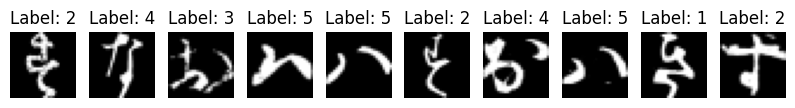

In [5]:
# Visualize some samples
print("Sample visualization from the training dataset:")
visualize_samples(train_dataset)

In [6]:

class VGGLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGLikeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Training VGG-like model
Epoch 1/20, Train Loss: 0.3298, Val Loss: 0.1260, Val Accuracy: 0.9576
Epoch 2/20, Train Loss: 0.1082, Val Loss: 0.0783, Val Accuracy: 0.9744
Epoch 3/20, Train Loss: 0.0718, Val Loss: 0.0640, Val Accuracy: 0.9807
Epoch 4/20, Train Loss: 0.0512, Val Loss: 0.0662, Val Accuracy: 0.9811
Epoch 5/20, Train Loss: 0.0421, Val Loss: 0.0605, Val Accuracy: 0.9836
Epoch 6/20, Train Loss: 0.0357, Val Loss: 0.0589, Val Accuracy: 0.9856
Epoch 7/20, Train Loss: 0.0269, Val Loss: 0.0651, Val Accuracy: 0.9856
Epoch 8/20, Train Loss: 0.0240, Val Loss: 0.0637, Val Accuracy: 0.9856
Epoch 9/20, Train Loss: 0.0240, Val Loss: 0.0700, Val Accuracy: 0.9835
Epoch 10/20, Train Loss: 0.0216, Val Loss: 0.0711, Val Accuracy: 0.9840
Epoch 11/20, Train Loss: 0.0174, Val Loss: 0.0732, Val Accuracy: 0.9856
Early stopping triggered! Stopping training.


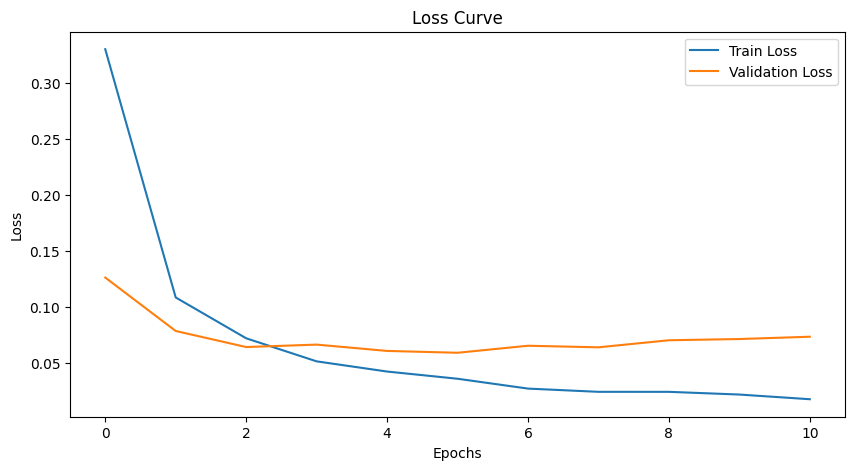

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.38      0.47      1000
           1       0.08      0.00      0.00      1000
           2       0.03      0.01      0.02      1000
           3       0.17      0.02      0.03      1000
           4       0.15      0.04      0.06      1000
           5       0.19      0.85      0.30      1000

    accuracy                           0.22      6000
   macro avg       0.21      0.22      0.15      6000
weighted avg       0.21      0.22      0.15      6000



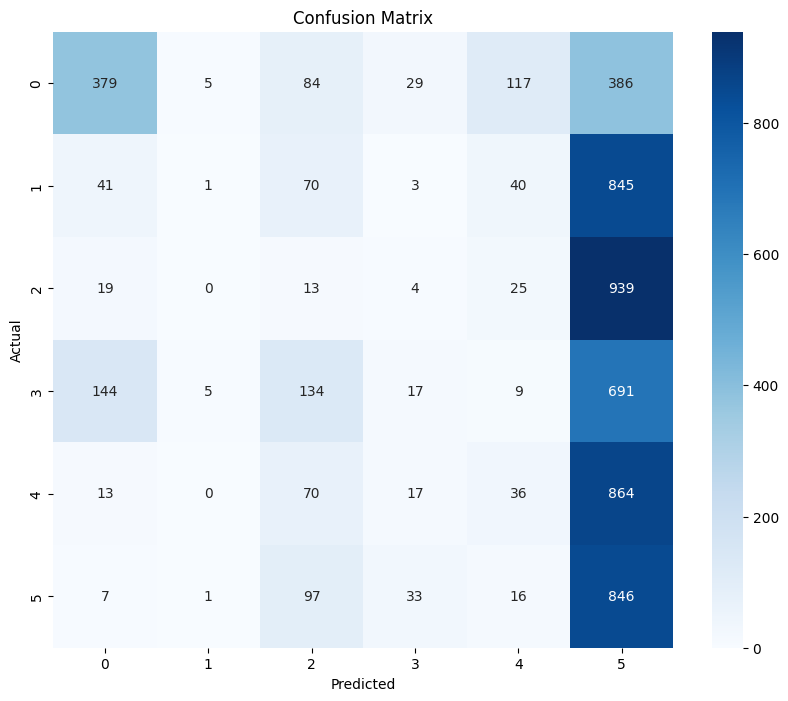

In [7]:
print("Training VGG-like model")
vgg_model = VGGLikeModel(num_classes)
vgg_model, val_accuracies = train_model(vgg_model, train_loader, val_loader)
evaluate_model(vgg_model, test_loader)

In [8]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResNetBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=(2 if downsample else 1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if downsample or in_channels != out_channels:
            self.residual_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = nn.ReLU()(x)
        return x

class ResNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeModel, self).__init__()
        self.layer1 = ResNetBlock(1, 64, downsample=True)
        self.layer2 = ResNetBlock(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Training ResNet-like model
Epoch 1/20, Train Loss: 0.3976, Val Loss: 0.2055, Val Accuracy: 0.9331
Epoch 2/20, Train Loss: 0.1206, Val Loss: 0.2110, Val Accuracy: 0.9315
Epoch 3/20, Train Loss: 0.0758, Val Loss: 0.2567, Val Accuracy: 0.9210
Epoch 4/20, Train Loss: 0.0487, Val Loss: 0.1128, Val Accuracy: 0.9650
Epoch 5/20, Train Loss: 0.0393, Val Loss: 0.2216, Val Accuracy: 0.9257
Epoch 6/20, Train Loss: 0.0307, Val Loss: 0.2742, Val Accuracy: 0.9242
Epoch 7/20, Train Loss: 0.0185, Val Loss: 0.0906, Val Accuracy: 0.9700
Epoch 8/20, Train Loss: 0.0192, Val Loss: 0.0967, Val Accuracy: 0.9717
Epoch 9/20, Train Loss: 0.0160, Val Loss: 0.0920, Val Accuracy: 0.9724
Epoch 10/20, Train Loss: 0.0158, Val Loss: 0.0890, Val Accuracy: 0.9746
Epoch 11/20, Train Loss: 0.0129, Val Loss: 0.1332, Val Accuracy: 0.9637
Epoch 12/20, Train Loss: 0.0104, Val Loss: 0.1358, Val Accuracy: 0.9656
Epoch 13/20, Train Loss: 0.0143, Val Loss: 0.1149, Val Accuracy: 0.9694
Epoch 14/20, Train Loss: 0.0093, Val Loss: 0.0

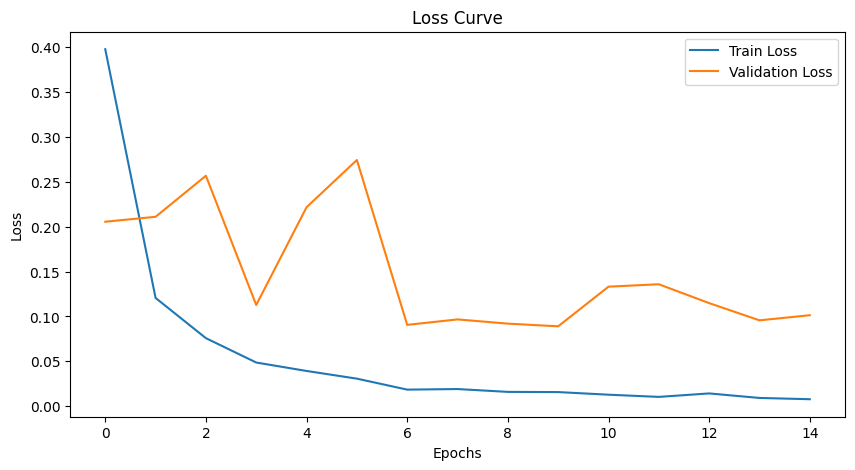

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1000
           1       0.12      0.04      0.06      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.38      0.16      0.23      1000
           5       0.18      0.94      0.30      1000

    accuracy                           0.19      6000
   macro avg       0.28      0.19      0.10      6000
weighted avg       0.28      0.19      0.10      6000



e:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


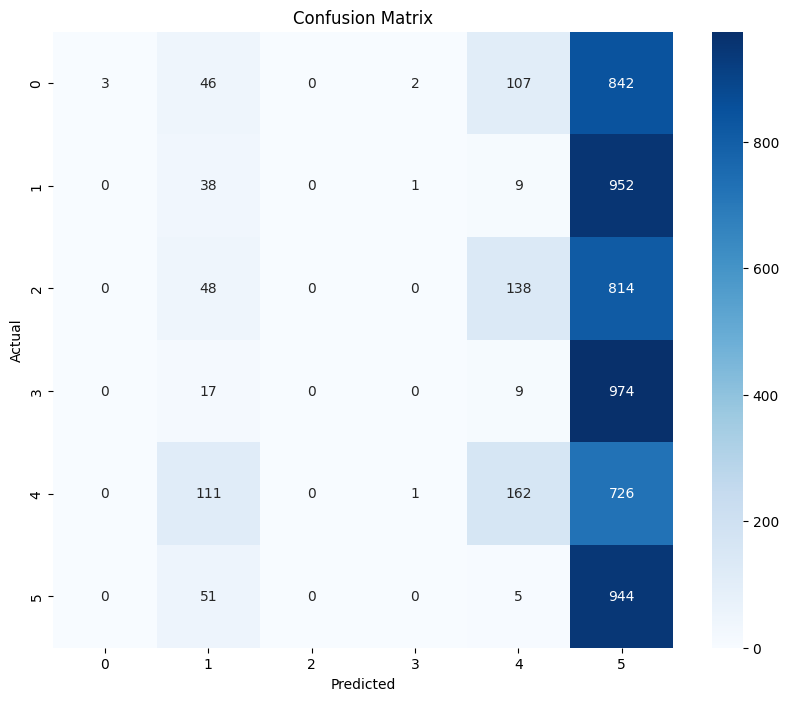

In [9]:
print("Training ResNet-like model")
resnet_model = ResNetLikeModel(num_classes)
resnet_model, val_accuracies = train_model(resnet_model, train_loader, val_loader)
evaluate_model(resnet_model, test_loader)

In [10]:
class EfficientNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetLikeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Training EfficientNet-like model
Epoch 1/20, Train Loss: 0.2805, Val Loss: 0.1133, Val Accuracy: 0.9644
Epoch 2/20, Train Loss: 0.1087, Val Loss: 0.0857, Val Accuracy: 0.9726
Epoch 3/20, Train Loss: 0.0733, Val Loss: 0.0821, Val Accuracy: 0.9742
Epoch 4/20, Train Loss: 0.0611, Val Loss: 0.0714, Val Accuracy: 0.9797
Epoch 5/20, Train Loss: 0.0510, Val Loss: 0.0709, Val Accuracy: 0.9807
Epoch 6/20, Train Loss: 0.0389, Val Loss: 0.0682, Val Accuracy: 0.9836
Epoch 7/20, Train Loss: 0.0371, Val Loss: 0.0791, Val Accuracy: 0.9818
Epoch 8/20, Train Loss: 0.0339, Val Loss: 0.0876, Val Accuracy: 0.9817
Epoch 9/20, Train Loss: 0.0286, Val Loss: 0.0770, Val Accuracy: 0.9825
Epoch 10/20, Train Loss: 0.0248, Val Loss: 0.0744, Val Accuracy: 0.9828
Epoch 11/20, Train Loss: 0.0248, Val Loss: 0.0750, Val Accuracy: 0.9865
Early stopping triggered! Stopping training.


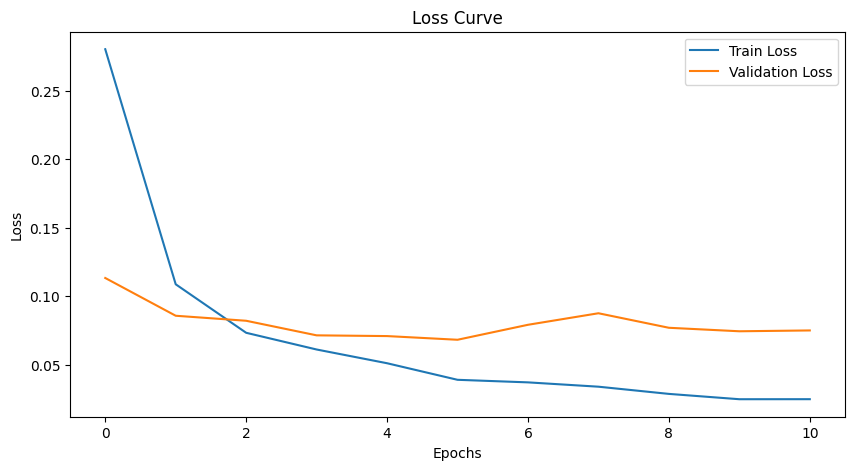

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.31      0.31      1000
           1       0.14      0.18      0.16      1000
           2       0.07      0.00      0.00      1000
           3       0.11      0.03      0.05      1000
           4       0.14      0.28      0.19      1000
           5       0.07      0.11      0.09      1000

    accuracy                           0.15      6000
   macro avg       0.14      0.15      0.13      6000
weighted avg       0.14      0.15      0.13      6000



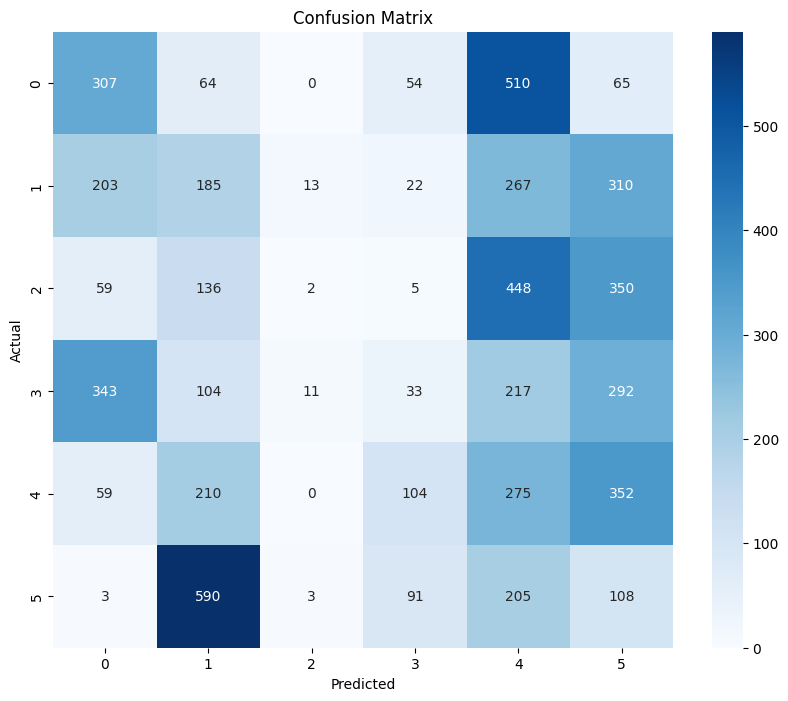

In [11]:

print("Training EfficientNet-like model")
efficientnet_model = EfficientNetLikeModel(num_classes)
efficientnet_model, val_accuracies = train_model(efficientnet_model, train_loader, val_loader)
evaluate_model(efficientnet_model, test_loader)

In [12]:
class VGGResNetHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGResNetHybridModel, self).__init__()
        
        # VGG-like feature extraction
        self.vgg_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # ResNet-like residual blocks
        self.res_block1 = ResNetBlock(64, 128, downsample=True)
        self.res_block2 = ResNetBlock(128, 256, downsample=True)
        
        # Placeholder for input features to the classifier
        self.flattened_size = None
        
        # Fully connected layers (set later dynamically)
        self.classifier = None
        self.num_classes = num_classes

    def forward(self, x):
        x = self.vgg_features(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # Dynamically calculate flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.classifier = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, self.num_classes),
            ).to(x.device)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


VGG and ResNet Hybrid model
Epoch 1/20, Train Loss: 0.1915, Val Loss: 0.0939, Val Accuracy: 0.9719
Epoch 2/20, Train Loss: 0.0519, Val Loss: 0.0589, Val Accuracy: 0.9810
Epoch 3/20, Train Loss: 0.0313, Val Loss: 0.0503, Val Accuracy: 0.9857
Epoch 4/20, Train Loss: 0.0154, Val Loss: 0.0631, Val Accuracy: 0.9824
Epoch 5/20, Train Loss: 0.0152, Val Loss: 0.0473, Val Accuracy: 0.9854
Epoch 6/20, Train Loss: 0.0098, Val Loss: 0.0627, Val Accuracy: 0.9799
Epoch 7/20, Train Loss: 0.0101, Val Loss: 0.0511, Val Accuracy: 0.9849
Epoch 8/20, Train Loss: 0.0093, Val Loss: 0.0527, Val Accuracy: 0.9839
Epoch 9/20, Train Loss: 0.0073, Val Loss: 0.0603, Val Accuracy: 0.9831
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0487, Val Accuracy: 0.9861
Early stopping triggered! Stopping training.


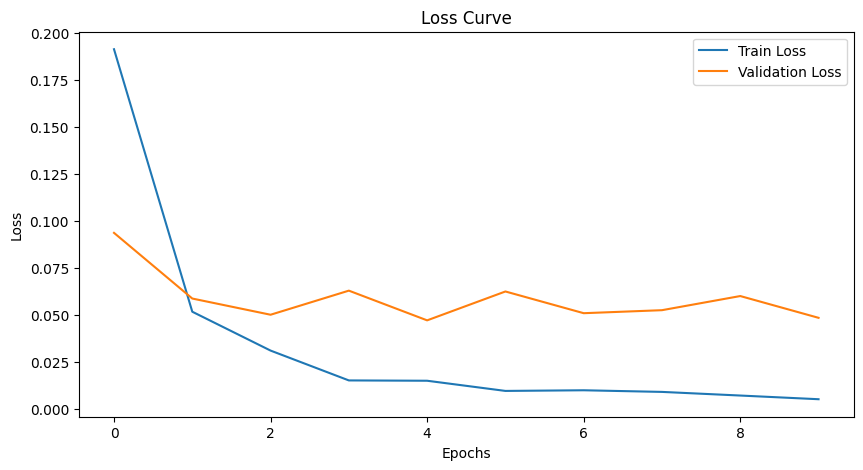

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.11      0.15      1000
           1       0.10      0.05      0.06      1000
           2       0.00      0.00      0.00      1000
           3       0.16      0.22      0.18      1000
           4       0.11      0.10      0.10      1000
           5       0.14      0.38      0.21      1000

    accuracy                           0.14      6000
   macro avg       0.12      0.14      0.12      6000
weighted avg       0.12      0.14      0.12      6000



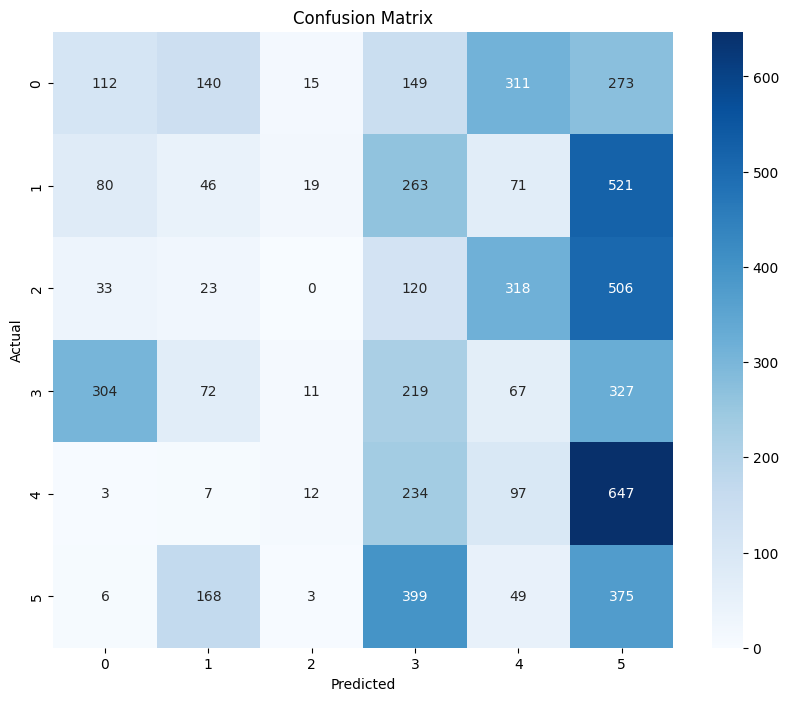

In [13]:
print("VGG and ResNet Hybrid model")
hybrid_model = VGGResNetHybridModel(num_classes)
hybrid_model, val_accuracies = train_model(hybrid_model, train_loader, val_loader)
evaluate_model(hybrid_model, test_loader)

### We have very bad accuracy as expexed (got max 22% on VGG model). What can we do:
1. Train models on TEST dataset. From data analysis we can see that TRAIN dataset doen't represent TEST2 dataset at all, so for futher training I won't use TRAIN dataset;
2. To impove accuracy, as the second step, I can also clear TEST dataset (which is train in this task) from images with black background (as TEST2 dataset consists only of white-background images presented only in TEST dataset). Here I expect better accuracy;
3. Try different normalization.

## Step 2.
Training model on TEST dataset and evaluating on TEST2 dataset.

In [6]:
# Paths
train_dir = os.path.join(root_dir, "TEST")
test_dir = os.path.join(root_dir, "TEST2")

# Data normalization
transform = transforms.Compose([
    # transforms.RandomRotation(10),  # Small random rotations
    # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Shearing & scaling
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0)),
    transforms.Normalize((0.5,), (0.5,))  # Keep normalization
])

# Prepare datasets
train2_dataset = SymbolDataset(root_dir, "TEST", transform=transform)
test2_dataset = SymbolDataset(root_dir, "TEST2", transform=transform)

# Split training into train and validation
train2_size = int(0.8 * len(train2_dataset))
val2_size = len(train2_dataset) - train2_size
train2_subset, val2_subset = random_split(train2_dataset, [train2_size, val2_size])

# Dataloaders
train2_loader = DataLoader(train2_subset, batch_size=64, shuffle=True)
val2_loader = DataLoader(val2_subset, batch_size=64, shuffle=False)

Sample visualization from the training dataset:


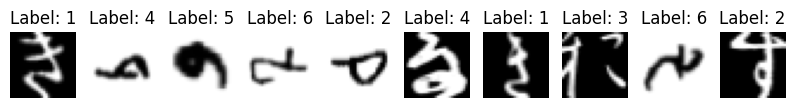

In [15]:
# Visualize some samples
print("Sample visualization from the training dataset:")
visualize_samples(train2_dataset)

Training VGG-like model trained on TEST dataset
Epoch 1/20, Train Loss: 1.1732, Val Loss: 0.6754, Val Accuracy: 0.7758
Epoch 2/20, Train Loss: 0.6279, Val Loss: 0.4838, Val Accuracy: 0.8525
Epoch 3/20, Train Loss: 0.4702, Val Loss: 0.3904, Val Accuracy: 0.8758
Epoch 4/20, Train Loss: 0.3904, Val Loss: 0.3299, Val Accuracy: 0.8942
Epoch 5/20, Train Loss: 0.3127, Val Loss: 0.3012, Val Accuracy: 0.9050
Epoch 6/20, Train Loss: 0.2791, Val Loss: 0.2881, Val Accuracy: 0.9108
Epoch 7/20, Train Loss: 0.2549, Val Loss: 0.2593, Val Accuracy: 0.9208
Epoch 8/20, Train Loss: 0.2090, Val Loss: 0.2477, Val Accuracy: 0.9283
Epoch 9/20, Train Loss: 0.1860, Val Loss: 0.2418, Val Accuracy: 0.9317
Epoch 10/20, Train Loss: 0.1645, Val Loss: 0.2230, Val Accuracy: 0.9308
Epoch 11/20, Train Loss: 0.1458, Val Loss: 0.2218, Val Accuracy: 0.9367
Epoch 12/20, Train Loss: 0.1625, Val Loss: 0.2330, Val Accuracy: 0.9325
Epoch 13/20, Train Loss: 0.1261, Val Loss: 0.2056, Val Accuracy: 0.9375
Epoch 14/20, Train Loss: 

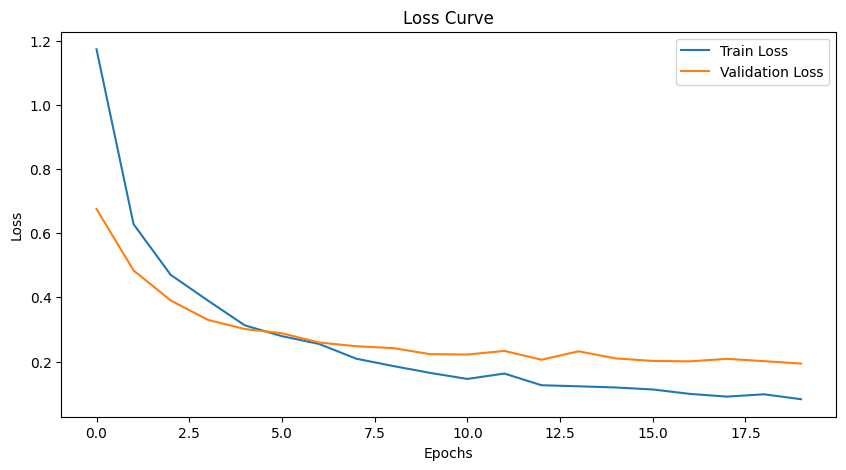

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1000
           1       0.99      0.96      0.97      1000
           2       0.96      0.97      0.97      1000
           3       0.92      0.98      0.95      1000
           4       0.98      0.95      0.96      1000
           5       0.98      0.98      0.98      1000

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000



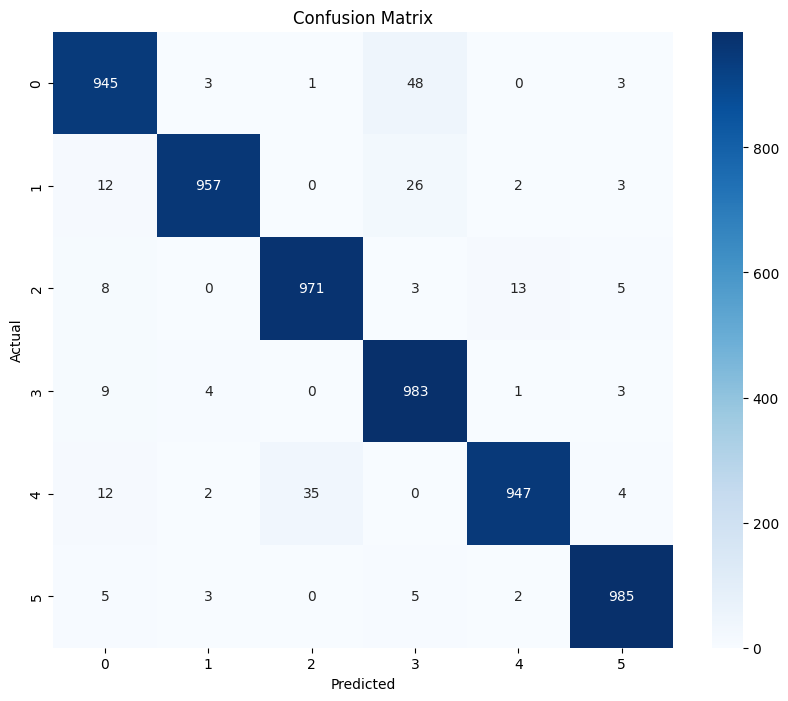

In [16]:
print("Training VGG-like model trained on TEST dataset")
vgg_model2 = VGGLikeModel(num_classes)
vgg_model2, val2_accuracies = train_model(vgg_model2, train2_loader, val2_loader)
evaluate_model(vgg_model2, test_loader)

Training ResNet-like model trained on TEST dataset
Epoch 1/20, Train Loss: 1.4549, Val Loss: 1.3269, Val Accuracy: 0.4458
Epoch 2/20, Train Loss: 0.9102, Val Loss: 0.8976, Val Accuracy: 0.6892
Epoch 3/20, Train Loss: 0.6003, Val Loss: 0.7424, Val Accuracy: 0.7392
Epoch 4/20, Train Loss: 0.4334, Val Loss: 0.5482, Val Accuracy: 0.8183
Epoch 5/20, Train Loss: 0.3724, Val Loss: 0.5185, Val Accuracy: 0.8192
Epoch 6/20, Train Loss: 0.2990, Val Loss: 0.5075, Val Accuracy: 0.8408
Epoch 7/20, Train Loss: 0.2535, Val Loss: 0.4453, Val Accuracy: 0.8558
Epoch 8/20, Train Loss: 0.2261, Val Loss: 0.5541, Val Accuracy: 0.8292
Epoch 9/20, Train Loss: 0.2178, Val Loss: 0.3811, Val Accuracy: 0.8742
Epoch 10/20, Train Loss: 0.1861, Val Loss: 0.4181, Val Accuracy: 0.8733
Epoch 11/20, Train Loss: 0.1639, Val Loss: 0.5595, Val Accuracy: 0.8258
Epoch 12/20, Train Loss: 0.1591, Val Loss: 0.4801, Val Accuracy: 0.8500
Epoch 13/20, Train Loss: 0.1374, Val Loss: 0.5595, Val Accuracy: 0.8283
Epoch 14/20, Train Los

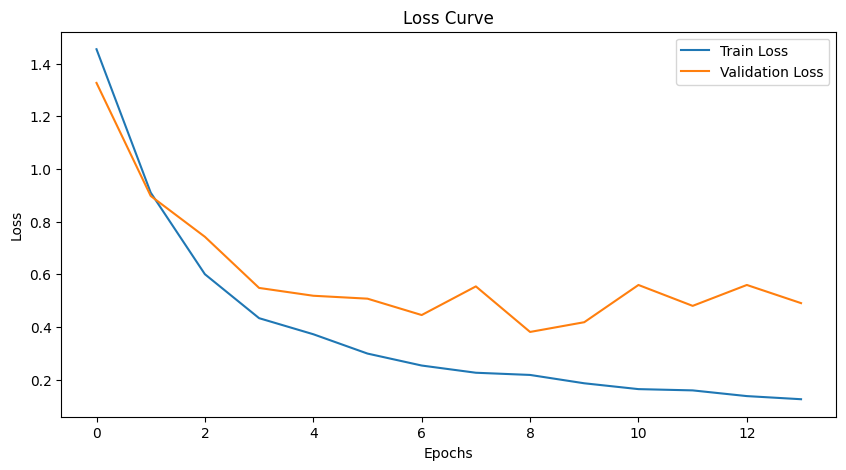

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1000
           1       0.99      0.91      0.95      1000
           2       0.87      0.99      0.93      1000
           3       0.95      0.92      0.94      1000
           4       0.95      0.91      0.93      1000
           5       0.81      0.99      0.89      1000

    accuracy                           0.92      6000
   macro avg       0.93      0.92      0.92      6000
weighted avg       0.93      0.92      0.92      6000



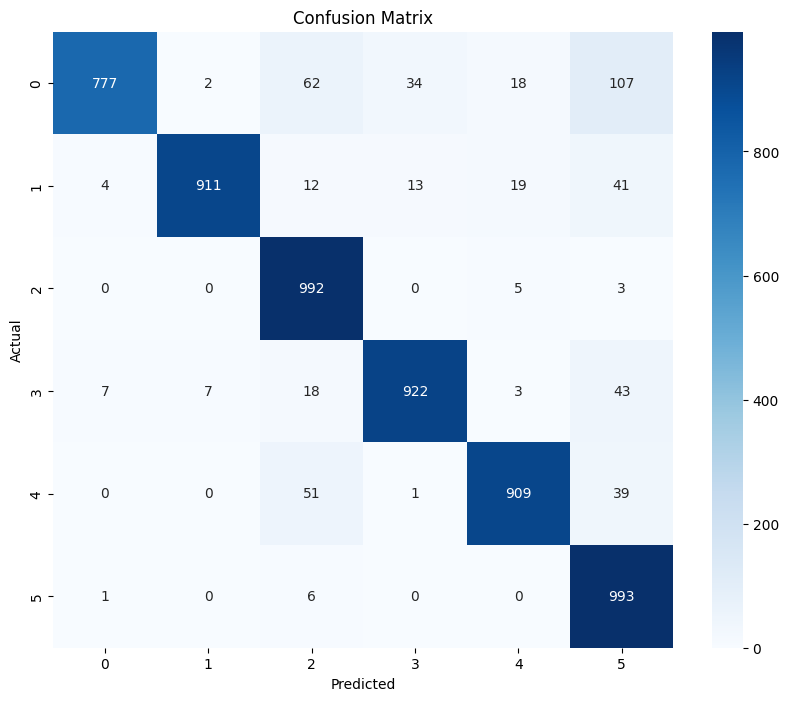

In [17]:
print("Training ResNet-like model trained on TEST dataset")
resnet_model2 = ResNetLikeModel(num_classes)
resnet_model2, val2_accuracies = train_model(resnet_model2, train2_loader, val2_loader)
evaluate_model(resnet_model2, test_loader)

Training EfficientNet-like model trained on TEST dataset
Epoch 1/20, Train Loss: 1.1018, Val Loss: 0.6228, Val Accuracy: 0.8100
Epoch 2/20, Train Loss: 0.6004, Val Loss: 0.5052, Val Accuracy: 0.8383
Epoch 3/20, Train Loss: 0.4810, Val Loss: 0.3945, Val Accuracy: 0.8917
Epoch 4/20, Train Loss: 0.3716, Val Loss: 0.3771, Val Accuracy: 0.8750
Epoch 5/20, Train Loss: 0.3515, Val Loss: 0.3515, Val Accuracy: 0.8950
Epoch 6/20, Train Loss: 0.3104, Val Loss: 0.3142, Val Accuracy: 0.9033
Epoch 7/20, Train Loss: 0.2820, Val Loss: 0.2810, Val Accuracy: 0.9067
Epoch 8/20, Train Loss: 0.2425, Val Loss: 0.2673, Val Accuracy: 0.9200
Epoch 9/20, Train Loss: 0.2226, Val Loss: 0.2586, Val Accuracy: 0.9283
Epoch 10/20, Train Loss: 0.2113, Val Loss: 0.2462, Val Accuracy: 0.9200
Epoch 11/20, Train Loss: 0.2195, Val Loss: 0.2567, Val Accuracy: 0.9283
Epoch 12/20, Train Loss: 0.1874, Val Loss: 0.2487, Val Accuracy: 0.9300
Epoch 13/20, Train Loss: 0.1803, Val Loss: 0.2596, Val Accuracy: 0.9233
Epoch 14/20, Tra

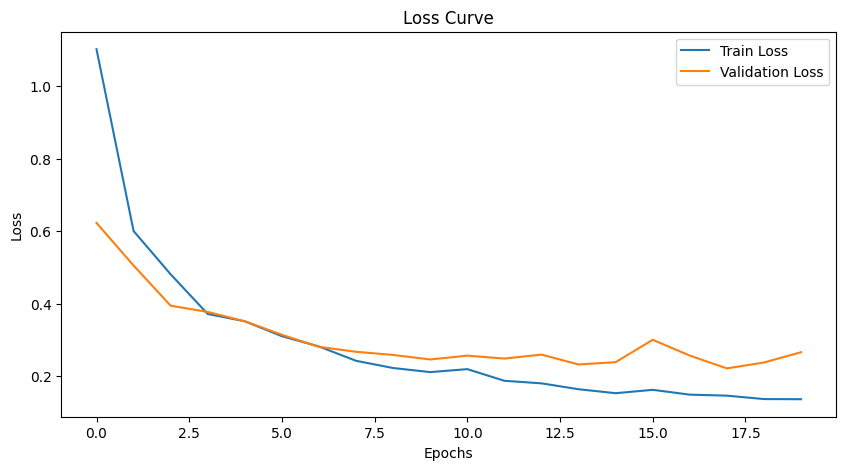

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.99      0.95      0.97      1000
           2       0.95      0.97      0.96      1000
           3       0.95      0.96      0.96      1000
           4       0.98      0.91      0.94      1000
           5       0.92      1.00      0.96      1000

    accuracy                           0.95      6000
   macro avg       0.96      0.95      0.95      6000
weighted avg       0.96      0.95      0.95      6000



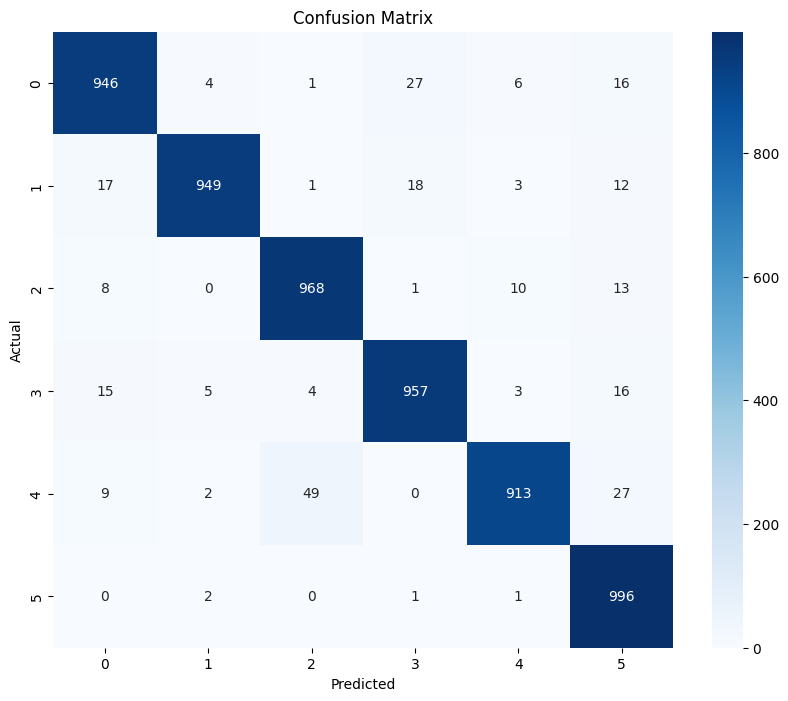

In [18]:

print("Training EfficientNet-like model trained on TEST dataset")
efficientnet_model2 = EfficientNetLikeModel(num_classes)
efficientnet_model2, val2_accuracies = train_model(efficientnet_model2, train2_loader, val2_loader)
evaluate_model(efficientnet_model2, test_loader)

VGG and ResNet Hybrid model trained on TEST dataset
Epoch 1/20, Train Loss: 0.8326, Val Loss: 0.5026, Val Accuracy: 0.8517
Epoch 2/20, Train Loss: 0.3578, Val Loss: 0.3141, Val Accuracy: 0.9033
Epoch 3/20, Train Loss: 0.2432, Val Loss: 0.2730, Val Accuracy: 0.9208
Epoch 4/20, Train Loss: 0.1759, Val Loss: 0.2462, Val Accuracy: 0.9242
Epoch 5/20, Train Loss: 0.1392, Val Loss: 0.2773, Val Accuracy: 0.9067
Epoch 6/20, Train Loss: 0.1078, Val Loss: 0.1876, Val Accuracy: 0.9450
Epoch 7/20, Train Loss: 0.0889, Val Loss: 0.2282, Val Accuracy: 0.9267
Epoch 8/20, Train Loss: 0.0892, Val Loss: 0.2120, Val Accuracy: 0.9358
Epoch 9/20, Train Loss: 0.0598, Val Loss: 0.1820, Val Accuracy: 0.9458
Epoch 10/20, Train Loss: 0.0555, Val Loss: 0.1591, Val Accuracy: 0.9533
Epoch 11/20, Train Loss: 0.0557, Val Loss: 0.1684, Val Accuracy: 0.9475
Epoch 12/20, Train Loss: 0.0494, Val Loss: 0.1836, Val Accuracy: 0.9417
Epoch 13/20, Train Loss: 0.0434, Val Loss: 0.1593, Val Accuracy: 0.9500
Epoch 14/20, Train Lo

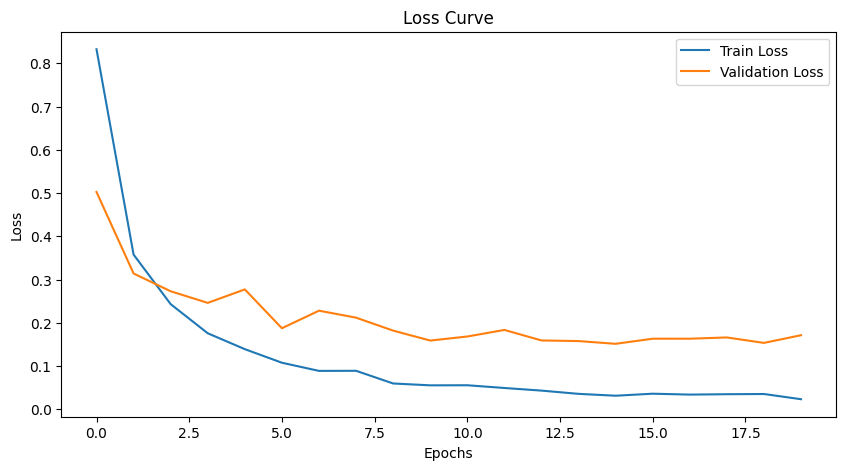

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1000
           1       0.95      0.98      0.97      1000
           2       0.99      0.96      0.97      1000
           3       0.99      0.95      0.97      1000
           4       0.97      0.97      0.97      1000
           5       0.99      0.98      0.99      1000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



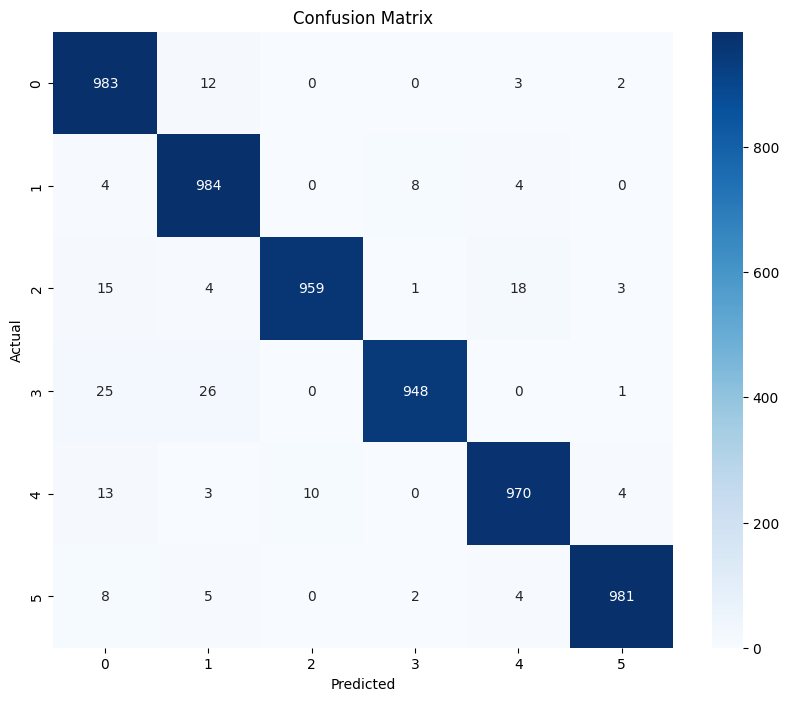

In [19]:
print("VGG and ResNet Hybrid model trained on TEST dataset")
hybrid_model2 = VGGResNetHybridModel(num_classes)
hybrid_model2, val2_accuracies = train_model(hybrid_model2, train2_loader, val2_loader)
evaluate_model(hybrid_model2, test_loader)

### I got maximum result 97% on Hybrid VGG and ResNet model.
Lets try to remove all images with black background for training


## Step 3. 
Training models on TRAIN3 dataset consists only of images from TEST dataset with white backgroung and evaluating on TEST2 dataset.

In [20]:

test_dir = os.path.join(root_dir, "TEST")
train3_dir = os.path.join(root_dir, "TRAIN3")

# Create TRAIN3 directory if it doesn't exist
if not os.path.exists(train3_dir):
    os.makedirs(train3_dir)

# Function to check if an image has a black background
def has_black_background(image, threshold=0.2):
    """ Check if more than `threshold`% of the pixels are dark """
    dark_pixels = np.sum(image < 0.2)  # Count pixels below 0.2 intensity
    total_pixels = image.size
    return dark_pixels / total_pixels > threshold

# Process each class folder (1-6)
for label in range(1, 7):
    class_dir = os.path.join(test_dir, str(label))
    new_class_dir = os.path.join(train3_dir, str(label))
    
    # Create class folder in TRAIN3 if it doesn't exist
    if not os.path.exists(new_class_dir):
        os.makedirs(new_class_dir)
    
    # Get all .npy files in the class folder
    file_names = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    
    for file_name in file_names:
        file_path = os.path.join(class_dir, file_name)
        image = np.load(file_path).astype(np.float32)  # Convert to float32
        image /= image.max()  # Normalize
        
        # Only save images that do NOT have a black background
        if not has_black_background(image):
            new_file_path = os.path.join(new_class_dir, file_name)
            shutil.copy(file_path, new_file_path)

print("TRAIN3 dataset created successfully with only non-black-background images.")


TRAIN3 dataset created successfully with only non-black-background images.


In [9]:
# Paths
train_dir = os.path.join(root_dir, "TRAIN3")
test_dir = os.path.join(root_dir, "TEST2")

# Data normalization
transform = transforms.Compose([
    # transforms.RandomRotation(5),  # Small random rotations
    # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Shearing & scaling
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0)),
    transforms.Normalize((0.5,), (0.5,))  # Keep normalization
])

# Prepare datasets
train3_dataset = SymbolDataset(root_dir, "TRAIN3", transform=transform)
test2_dataset = SymbolDataset(root_dir, "TEST2", transform=transform)

# Split training into train and validation
train3_size = int(0.8 * len(train3_dataset))
val3_size = len(train3_dataset) - train3_size
train3_subset, val3_subset = random_split(train3_dataset, [train3_size, val3_size])

# Dataloaders
train3_loader = DataLoader(train3_subset, batch_size=64, shuffle=True)
val3_loader = DataLoader(val3_subset, batch_size=64, shuffle=False)

Sample visualization from the training dataset:


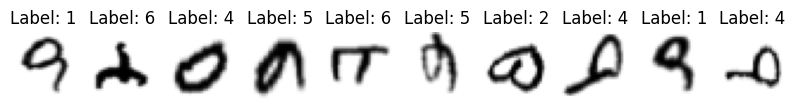

In [22]:
# Visualize some samples
print("Sample visualization from the training dataset:")
visualize_samples(train3_dataset)

Training VGG-like model trained on TRAIN3 dataset with non-black-background images
Epoch 1/20, Train Loss: 1.0753, Val Loss: 0.5484, Val Accuracy: 0.8133
Epoch 2/20, Train Loss: 0.5102, Val Loss: 0.3697, Val Accuracy: 0.8850
Epoch 3/20, Train Loss: 0.3688, Val Loss: 0.2727, Val Accuracy: 0.9167
Epoch 4/20, Train Loss: 0.2821, Val Loss: 0.2727, Val Accuracy: 0.9167
Epoch 5/20, Train Loss: 0.2412, Val Loss: 0.2085, Val Accuracy: 0.9317
Epoch 6/20, Train Loss: 0.1880, Val Loss: 0.2048, Val Accuracy: 0.9350
Epoch 7/20, Train Loss: 0.1780, Val Loss: 0.1983, Val Accuracy: 0.9450
Epoch 8/20, Train Loss: 0.1519, Val Loss: 0.1717, Val Accuracy: 0.9483
Epoch 9/20, Train Loss: 0.1428, Val Loss: 0.1743, Val Accuracy: 0.9383
Epoch 10/20, Train Loss: 0.1328, Val Loss: 0.1524, Val Accuracy: 0.9533
Epoch 11/20, Train Loss: 0.0987, Val Loss: 0.1809, Val Accuracy: 0.9433
Epoch 12/20, Train Loss: 0.1082, Val Loss: 0.1836, Val Accuracy: 0.9450
Epoch 13/20, Train Loss: 0.0932, Val Loss: 0.1466, Val Accurac

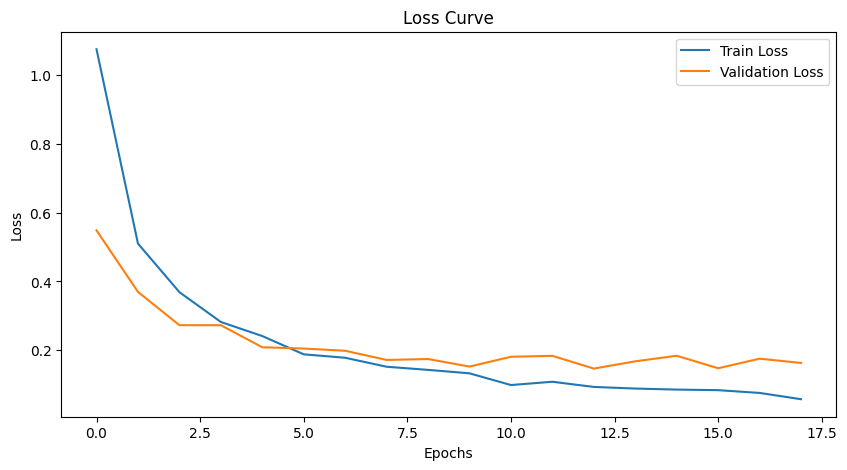

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1000
           1       0.95      0.98      0.96      1000
           2       0.95      0.98      0.96      1000
           3       0.97      0.95      0.96      1000
           4       0.98      0.92      0.95      1000
           5       0.99      0.98      0.98      1000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



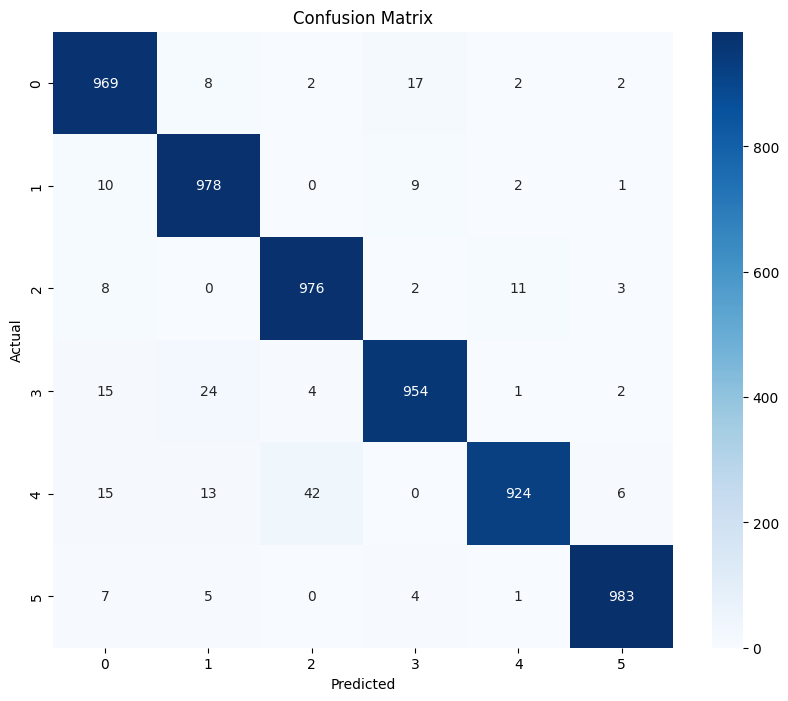

In [23]:
print("Training VGG-like model trained on TRAIN3 dataset with non-black-background images")
vgg_model3 = VGGLikeModel(num_classes)
vgg_model3, val3_accuracies = train_model(vgg_model3, train3_loader, val3_loader)
evaluate_model(vgg_model3, test_loader)

Training ResNet-like model trained on TRAIN3 dataset with non-black-background images
Epoch 1/20, Train Loss: 1.1612, Val Loss: 1.0636, Val Accuracy: 0.6550
Epoch 2/20, Train Loss: 0.5910, Val Loss: 0.8755, Val Accuracy: 0.6783
Epoch 3/20, Train Loss: 0.3609, Val Loss: 0.5391, Val Accuracy: 0.8283
Epoch 4/20, Train Loss: 0.2610, Val Loss: 0.3464, Val Accuracy: 0.9050
Epoch 5/20, Train Loss: 0.2085, Val Loss: 0.4770, Val Accuracy: 0.8333
Epoch 6/20, Train Loss: 0.1591, Val Loss: 0.4514, Val Accuracy: 0.8317
Epoch 7/20, Train Loss: 0.1525, Val Loss: 0.2790, Val Accuracy: 0.9050
Epoch 8/20, Train Loss: 0.1387, Val Loss: 0.1895, Val Accuracy: 0.9417
Epoch 9/20, Train Loss: 0.1117, Val Loss: 0.6659, Val Accuracy: 0.7333
Epoch 10/20, Train Loss: 0.1158, Val Loss: 0.2958, Val Accuracy: 0.9050
Epoch 11/20, Train Loss: 0.0940, Val Loss: 0.1373, Val Accuracy: 0.9550
Epoch 12/20, Train Loss: 0.0775, Val Loss: 0.1835, Val Accuracy: 0.9367
Epoch 13/20, Train Loss: 0.0704, Val Loss: 0.1341, Val Accu

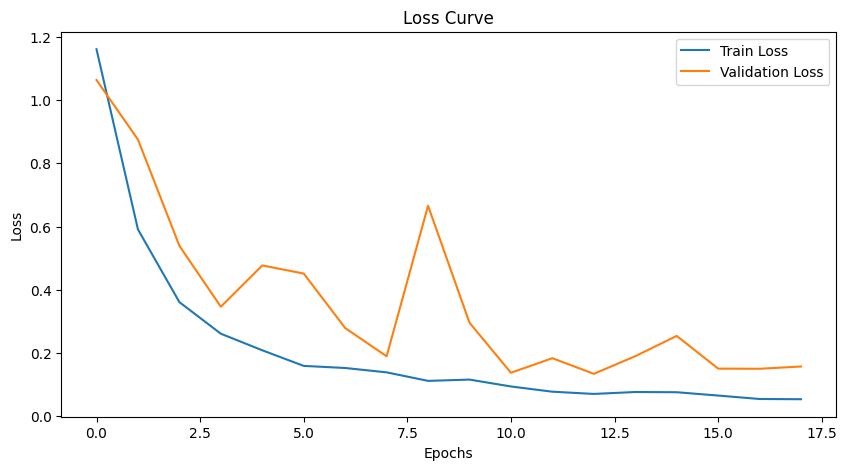

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1000
           1       0.99      0.91      0.95      1000
           2       0.96      0.99      0.97      1000
           3       0.93      0.98      0.95      1000
           4       0.99      0.93      0.96      1000
           5       0.95      0.99      0.97      1000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



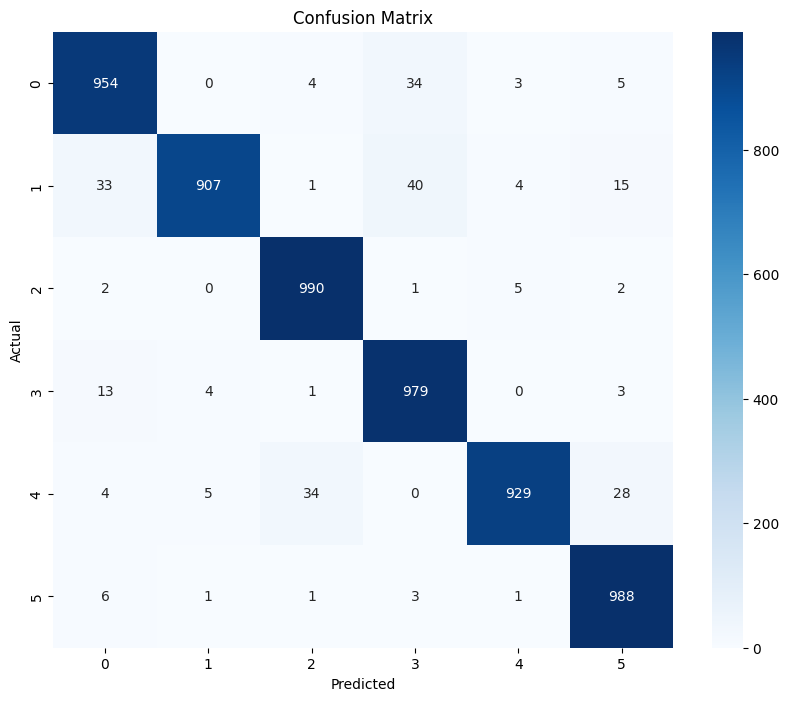

In [27]:
print("Training ResNet-like model trained on TRAIN3 dataset with non-black-background images")
resnet_model3 = ResNetLikeModel(num_classes)
resnet_model3, val3_accuracies = train_model(resnet_model3, train3_loader, val3_loader)
evaluate_model(resnet_model3, test_loader)

Training EfficientNet-like model trained on TRAIN3 dataset with non-black-background images
Epoch 1/20, Train Loss: 0.8680, Val Loss: 0.5186, Val Accuracy: 0.8217
Epoch 2/20, Train Loss: 0.3957, Val Loss: 0.2979, Val Accuracy: 0.9017
Epoch 3/20, Train Loss: 0.2654, Val Loss: 0.2545, Val Accuracy: 0.9150
Epoch 4/20, Train Loss: 0.2146, Val Loss: 0.1860, Val Accuracy: 0.9383
Epoch 5/20, Train Loss: 0.1928, Val Loss: 0.2423, Val Accuracy: 0.9183
Epoch 6/20, Train Loss: 0.1803, Val Loss: 0.1679, Val Accuracy: 0.9467
Epoch 7/20, Train Loss: 0.1502, Val Loss: 0.1612, Val Accuracy: 0.9517
Epoch 8/20, Train Loss: 0.1315, Val Loss: 0.1596, Val Accuracy: 0.9417
Epoch 9/20, Train Loss: 0.1235, Val Loss: 0.1344, Val Accuracy: 0.9550
Epoch 10/20, Train Loss: 0.1076, Val Loss: 0.1444, Val Accuracy: 0.9500
Epoch 11/20, Train Loss: 0.0994, Val Loss: 0.1877, Val Accuracy: 0.9533
Epoch 12/20, Train Loss: 0.0922, Val Loss: 0.1579, Val Accuracy: 0.9533
Epoch 13/20, Train Loss: 0.1012, Val Loss: 0.1554, Va

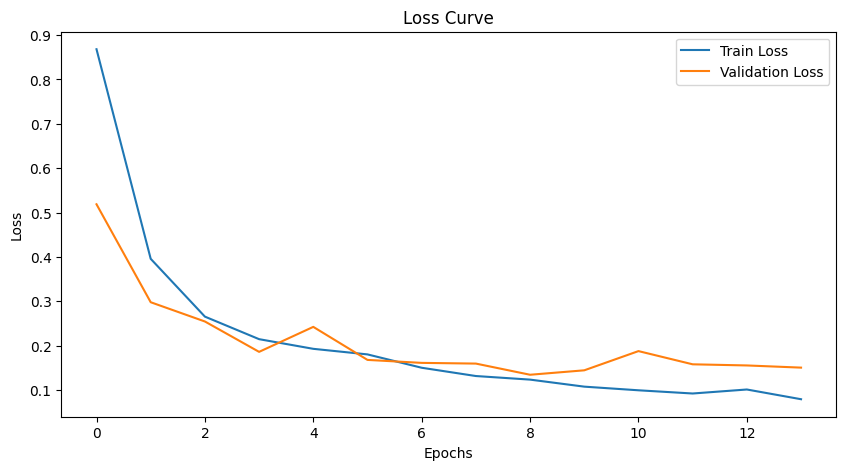

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.96      0.98      0.97      1000
           2       0.99      0.95      0.97      1000
           3       0.96      0.96      0.96      1000
           4       0.97      0.96      0.96      1000
           5       0.96      0.99      0.97      1000

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000



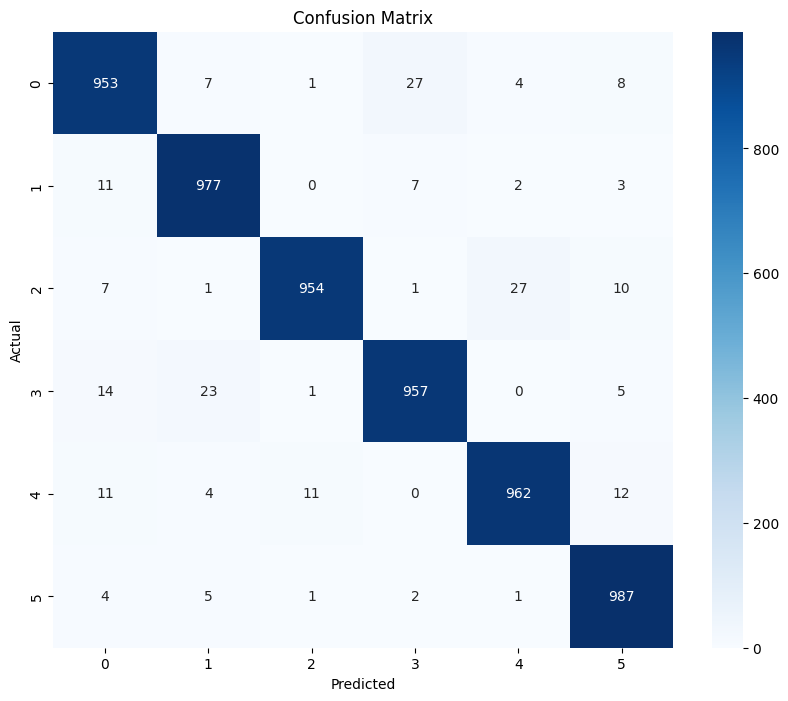

In [25]:
print("Training EfficientNet-like model trained on TRAIN3 dataset with non-black-background images")
efficientnet_model3= EfficientNetLikeModel(num_classes)
efficientnet_model3, val3_accuracies = train_model(efficientnet_model3, train3_loader, val3_loader)
evaluate_model(efficientnet_model3, test_loader)

VGG and ResNet Hybrid model trained on TRAIN3 dataset with non-black-background images
Epoch 1/20, Train Loss: 0.7312, Val Loss: 0.5121, Val Accuracy: 0.8850
Epoch 2/20, Train Loss: 0.2745, Val Loss: 0.3993, Val Accuracy: 0.8817
Epoch 3/20, Train Loss: 0.1868, Val Loss: 0.3116, Val Accuracy: 0.9117
Epoch 4/20, Train Loss: 0.1601, Val Loss: 0.2155, Val Accuracy: 0.9417
Epoch 5/20, Train Loss: 0.1229, Val Loss: 0.2246, Val Accuracy: 0.9283
Epoch 6/20, Train Loss: 0.0964, Val Loss: 0.1868, Val Accuracy: 0.9433
Epoch 7/20, Train Loss: 0.0790, Val Loss: 0.1253, Val Accuracy: 0.9717
Epoch 8/20, Train Loss: 0.0681, Val Loss: 0.1619, Val Accuracy: 0.9567
Epoch 9/20, Train Loss: 0.0612, Val Loss: 0.1406, Val Accuracy: 0.9617
Epoch 10/20, Train Loss: 0.0523, Val Loss: 0.1661, Val Accuracy: 0.9483
Epoch 11/20, Train Loss: 0.0414, Val Loss: 0.1033, Val Accuracy: 0.9700
Epoch 12/20, Train Loss: 0.0424, Val Loss: 0.1314, Val Accuracy: 0.9600
Epoch 13/20, Train Loss: 0.0282, Val Loss: 0.1249, Val Acc

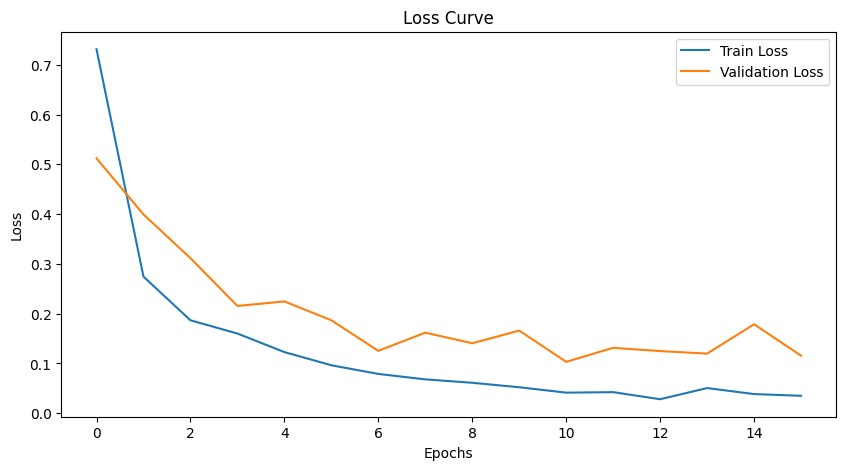

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1000
           1       0.99      0.94      0.96      1000
           2       0.98      0.96      0.97      1000
           3       0.98      0.98      0.98      1000
           4       0.97      0.96      0.97      1000
           5       0.99      0.98      0.98      1000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



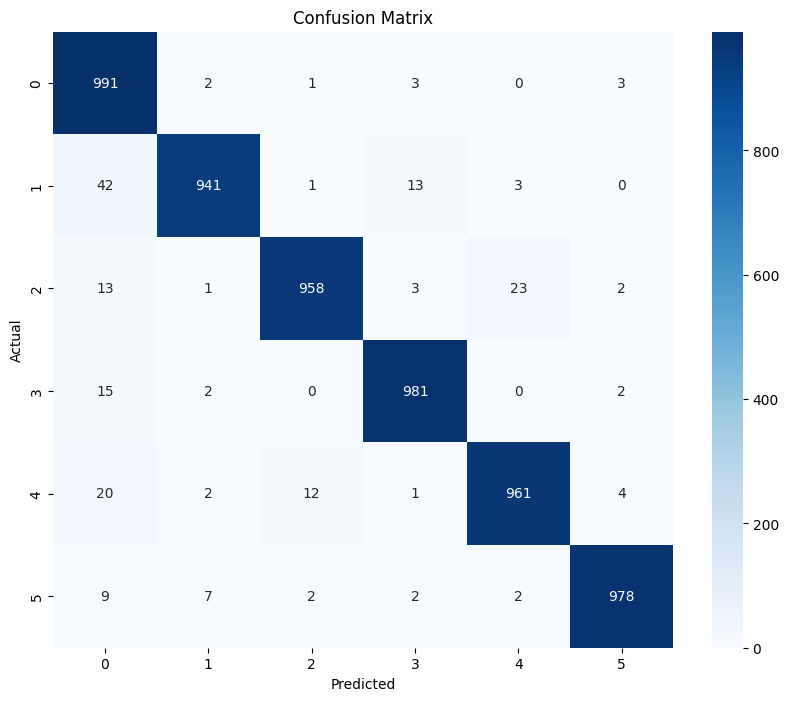

In [26]:
print("VGG and ResNet Hybrid model trained on TRAIN3 dataset with non-black-background images")
hybrid_model3 = VGGResNetHybridModel(num_classes)
hybrid_model3, val3_accuracies = train_model(hybrid_model3, train3_loader, val3_loader)
evaluate_model(hybrid_model3, test_loader)